In [1]:
from sklearn.datasets import make_circles

# Generate 2 circles as dataset

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03, # Make Noise
                    random_state = 42 # Same as manual_seed(42)
                    )

In [2]:
# Convert to Dataframe
import pandas as pd

circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
# Check
circles.label.value_counts()

,count
label,
1,500
0,500


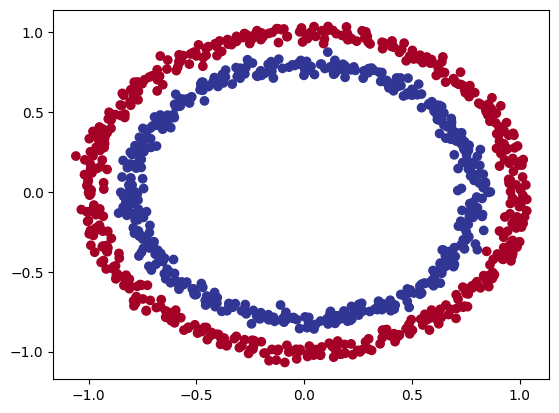

In [4]:
### Plotting
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [5]:
# Check shape
X.shape, y.shape

((1000, 2), (1000,))

This tells us that (in_features = 2, out_features = 1)

In [6]:
### Data Preprocessing
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2, # (80% Train, 20% Test)
    random_state = 42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
### Building Model

from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Current device: {device}")

Current device: cuda


In [55]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Number of Nodes through each layer: (2,5,1)
        self.layer_1 = nn.Linear(in_features = 2, out_features = 512)
        self.layer_2 = nn.Linear(in_features = 512, out_features = 128)
        self.layer_3 = nn.Linear(in_features = 128, out_features = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # self.layer_5(self.relu(self.layer_4(self.relu(
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
# 2nd way to create the model above

# # Replicate CircleModelV0 with nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0


Why not just always use nn.Sequential?

-> nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order. If you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

In [10]:
### Evaluation Metric
def accuracy_function(y_true, y_pred):
    # Calculate where those two are equal
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

<center>
  <img src="https://i.ytimg.com/vi/zhrfBCNSO1Q/maxresdefault.jpg" alt="Sample Image">
</center>

In [56]:
### Training and Testing

# Binary Cross Entropy Loss with Sigmoid function built-in (So we don't have to convert logits into probability using sigmoid function)
torch.manual_seed(42)

loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward-pass
    y_logits = model_0(X_train).squeeze() # Remove extra '1' dimension
    y_pred = torch.round(torch.sigmoid(y_logits)) # Logits -> Probabilities -> Prediction

    # 2. Calculate loss/accuracy
    loss = loss_function(y_logits, y_train) # If loss function is nn.BCELoss: loss_function(torch.sigmoid(y_logits), y_train)
    acc = accuracy_function(y_true = y_train, y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Calculate gradients for back prop
    loss.backward()
    # 5. Updates parameters
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward-pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_function(y_true = y_test, y_pred = test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69482, Accuracy: 50.00% | Test loss: 0.69281, Test acc: 50.00%
Epoch: 10 | Loss: 0.68670, Accuracy: 50.00% | Test loss: 0.68699, Test acc: 50.00%
Epoch: 20 | Loss: 0.68115, Accuracy: 59.88% | Test loss: 0.68269, Test acc: 58.50%
Epoch: 30 | Loss: 0.67536, Accuracy: 70.12% | Test loss: 0.67791, Test acc: 67.50%
Epoch: 40 | Loss: 0.66880, Accuracy: 77.62% | Test loss: 0.67225, Test acc: 74.50%
Epoch: 50 | Loss: 0.66105, Accuracy: 84.88% | Test loss: 0.66547, Test acc: 80.00%
Epoch: 60 | Loss: 0.65185, Accuracy: 88.12% | Test loss: 0.65733, Test acc: 83.00%
Epoch: 70 | Loss: 0.64081, Accuracy: 91.50% | Test loss: 0.64743, Test acc: 88.50%
Epoch: 80 | Loss: 0.62729, Accuracy: 94.88% | Test loss: 0.63528, Test acc: 92.50%
Epoch: 90 | Loss: 0.61117, Accuracy: 97.62% | Test loss: 0.62071, Test acc: 96.00%


In [39]:
### Visualization
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


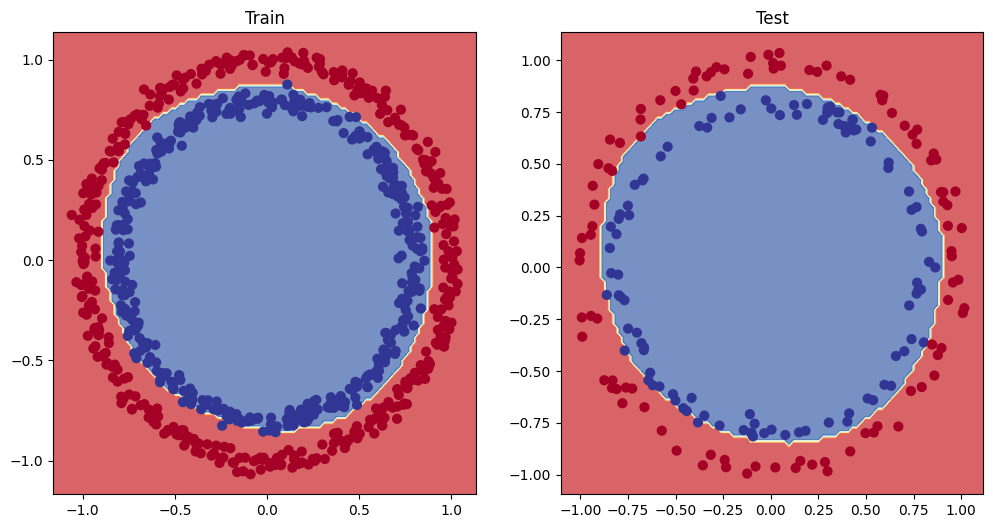

In [57]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)